In [74]:
import numpy as np
import os
import time
import regex as re
import subprocess
import urllib
import functools

import torch.distributions.distribution
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

from MySong import *
from Graph import PeriodicPlotter
from LSTM_Model import *

if(torch.cuda.is_available()):
    print("GPU: ",torch.cuda.get_device_name(0)," is available, Switching now.")
else:
    print("GPU is not available, using CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is now: ", device)

GPU is not available, using CPU.
Device is now:  cpu


In [75]:
train = True
inference = True
### Hyperparameter setting and optimization ###

epochs = 1

# Optimization parameters:
num_training_iterations = 10000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 25e-3  # Experiment between 1e-5 and 1e-1

# Model parameters:
embedding_dim = 256
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location:
checkpoint_dir = 'training_checkpoints_pytorch'
checkpoint_prefix = 'my_ckpt.pth'

checkpoint_dir = os.path.join(cwd, checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, checkpoint_prefix)

In [76]:
songs = []
with open(os.path.join(cwd, 'dataset', 'irish.abc'), 'r') as f:
    text = f.read()
    songs = extract_song_snippet(text)

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

# need abc2midi and timidity
#play_song(example_song)

Found 818 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [77]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

vocab_size = len(vocab)

### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)  ### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u: i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

### Vectorize the songs string ###

'''
  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''


def vectorize_string(string):
    vectorized_list = np.array([char2idx[s] for s in string])
    return vectorized_list


vectorized_songs = vectorize_string(songs_joined)

print('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"


def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True


def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True


def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:, 1:] == y[:, :-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True


### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)

    input_batch = [vectorized_songs[i:i + seq_length] for i in idx]
    output_batch = [vectorized_songs[i + 1: i + 1 + seq_length] for i in idx]

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, seq_length])
    y_batch = np.reshape(output_batch, [batch_size, seq_length])
    return x_batch, y_batch

There are 83 unique characters in the dataset
{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}
'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [78]:
# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not test_batch_func_types(get_batch, test_args) or \
        not test_batch_func_shapes(get_batch, test_args) or \
        not test_batch_func_next_step(get_batch, test_args):
    print("======\n[FAIL] could not pass tests")
else:
    print("======\n[PASS] passed all tests!")

x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!
Step   0
  input: 32 ('G')
  expected output: 26 ('A')
Step   1
  input: 26 ('A')
  expected output: 27 ('B')
Step   2
  input: 27 ('B')
  expected output: 58 ('c')
Step   3
  input: 58 ('c')
  expected output: 82 ('|')
Step   4
  input: 82 ('|')
  expected output: 59 ('d')


In [79]:
# Build a simple model with default hyperparameters. You will get the
#   chance to change these later.
#model = MusicGenerator(len(vocab), embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=batch_size, seq_length=seq_length)

model = MyLSTM(vocab_size, embedding_dim, rnn_units, batch_size, seq_length)
model.to(device)
print(model)

x, y = get_batch(vectorized_songs, seq_length=100, batch_size=4)

hn = torch.zeros(1, 1, rnn_units).to(device)  # [num_layers*num_directions,batch,hidden_size]
cn = torch.zeros(1, 1, rnn_units).to(device)  # [num_layers*num_directions,batch,hidden_size]
x = torch.tensor(x).to(device)
pred, (hn, cn) = model(x, hn, cn)
#pred = model(x)

print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = torch.distributions.categorical.Categorical(logits=pred[0]).sample()
sampled_indices = torch.squeeze(sampled_indices, dim=-1).cpu().numpy()

print("Input: \n", repr("".join(idx2char[x.cpu()[0]])))
# print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

MyLSTM(
  (embedding): Embedding(400, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (linear): Linear(in_features=1024, out_features=83, bias=True)
)
Input shape:       torch.Size([4, 100])  # (batch_size, sequence_length)
Prediction shape:  torch.Size([4, 100, 83]) # (batch_size, sequence_length, vocab_size)
Input: 
 'Mixolydian\nA|d^cd A2G|F2D DED|EDE cBc|E2D DFA|!\ndcB cBA|BAG A2G|EDE cBc|E2D D2:|!\ne|f2d d^cd|f2d d^c'
Next Char Predictions: 
 "rlTgn!D|WisF0|tN <DMi/ )u\nDtd_m_OqjS:qSjP#w/hBbXEgNWEm|d-8t4x)_0MIglWzQK8KLyi/V!axWX4LI8tp)O[)4'PbKB"


In [80]:
### Defining the loss function ###

def compute_loss(labels, logits):
    x = logits.permute((0, 2, 1))  # shape of preds must be (N, C, H, W) instead of (N, H, W, C)
    x.to(device)
    y = torch.tensor(labels, device=device).long()  # shape of labels must be (N, H, W) and type must be long integer
    F = torch.nn.CrossEntropyLoss()
    loss = F(x, y)
    loss.to(device)
    return loss

example_batch_loss = compute_loss(y, pred)

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
'''
example_batch_loss.numpy().mean() = 4.417909
'''
print("scalar_loss:      ", example_batch_loss.cpu().detach().numpy().mean())
print(example_batch_loss)

Prediction shape:  torch.Size([4, 100, 83])  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.418102
tensor(4.4181, grad_fn=<NllLoss2DBackward0>)


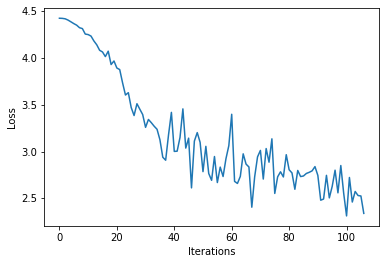

  1%|          | 107/10000 [09:04<13:58:55,  5.09s/it]


KeyboardInterrupt: 

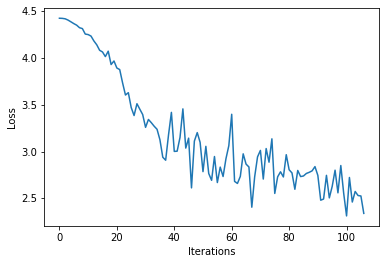

In [81]:
checkpoint_dir = os.path.join(cwd, checkpoint_dir)
#try to create pytorch training checkpoints directory
try:
    os.mkdir(checkpoint_dir)
except FileExistsError:
    print("The pytorch training directory already exists...")

checkpoint_prefix = os.path.join(checkpoint_dir, checkpoint_prefix)

### Define optimizer and training operation ###

model = MyLSTM(vocab_size, embedding_dim, rnn_units, batch_size, seq_length)
model.to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

def torch_train(x, y, hn, cn):
    x = torch.tensor(x).to(device)
    optimizer.zero_grad()
    # forward pass and loss calculation
    # implicit tape-based AD
    y_hat, (hn, cn) = model(x, hn, cn)
    y_hat.to(device)
    hn.to(device)
    cn.to(device)
    loss = compute_loss(y, y_hat)

    # compute gradients (grad)
    loss.backward()
    optimizer.step()
    return loss, (hn, cn)

if train:

    # try to create pytorch training checkpoints directory
    try:
        os.mkdir(checkpoint_dir)
    except FileExistsError:
        print("The pytorch training directory already exists...")

    ##################
    # Begin training!#
    ##################
    history = []
    plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
    if hasattr(tqdm, '_instances'): tqdm._instances.clear()  # clear if it exists

    for epoch in range(epochs):
        hn = torch.zeros(1, 1, rnn_units).to(device)  # [num_layers*num_directions,batch,hidden_size]
        cn = torch.zeros(1, 1, rnn_units).to(device)  # [num_layers*num_directions,batch,hidden_size]

        for iter in tqdm(range(num_training_iterations)):

            # Grab a batch and propagate it through the network
            x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
            loss, (hn, cn) = torch_train(x_batch, y_batch, hn, cn)

            # Update the progress bar
            history.append(loss.cpu().detach().numpy().mean())
            plotter.plot(history)

            # Update the model with the changed weights!
            if iter % 100 == 0:
                torch.save(model.state_dict(), checkpoint_prefix)

    # Save the trained model and the weights
    torch.save(model.state_dict(), checkpoint_prefix)


if(inference):

    ### Prediction of a generated song ###

    def generate_text(model, start_string, generation_length=1000):
        # Evaluation step (generating ABC text using the learned RNN model)

        input_eval = [char2idx[s] for s in start_string]
        input_eval = np.expand_dims(input_eval, axis=0)

        # Empty string to store our results
        text_generated = []

        # Here batch size == 1
        '''
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        '''
        hn = torch.zeros(1, 1, rnn_units).to(device)  # [num_layers*num_directions,batch,hidden_size]
        cn = torch.zeros(1, 1, rnn_units).to(device)  # [num_layers*num_directions,batch,hidden_size]

        tqdm._instances.clear()

        for i in tqdm(range(generation_length)):
            input_eval = torch.tensor(input_eval).to(device)
            predictions, (hn, cn) = model(input_eval, hn, cn)
            predictions.to(device)

            # Remove the batch dimension
            # predictions = tf.squeeze(predictions, 0)
            predictions = torch.squeeze(predictions, dim=0)

            # predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
            predicted_id = torch.distributions.categorical.Categorical(logits=predictions).sample()[0].cpu().numpy()
            # predicted_id = torch.distributions.categorical.Categorical(logits=predictions)

            # Pass the prediction along with the previous hidden state
            #   as the next inputs to the model
            input_eval = np.expand_dims(np.array([predicted_id]), axis=0)

            '''add the predicted character to the generated text!'''
            # Hint: consider what format the prediction is in vs. the output
            text_generated.append(idx2char[predicted_id])

        return (start_string + ''.join(text_generated))

    # Restore the model weights for the last checkpoint after training
    model = MyLSTM(vocab_size, embedding_dim, rnn_units, batch_size, seq_length)
    model.to(device)
    model.load_state_dict(torch.load(checkpoint_prefix))
    model.eval()
    print(model)

    '''Use the model and the function defined above to generate ABC format text of length 1000!
        As you may notice, ABC files start with "X" - this may be a good start string.'''
    generated_text = generate_text(model, start_string="X", generation_length=1000)

    generated_songs = extract_song_snippet(generated_text)

    for i, song in enumerate(generated_songs):
        # could be incorrect ABC notational syntax, save the ABC file anyway...
        print("---------------------------------------------------------------")
        print("Generated song", i)
        n = "gan_song_{}".format(i)
        basename = os.path.join(op, save_song_to_abc(song, filename=n))
        abc2wav(basename + '.abc')